In [1]:
from experiment_utils.power_sim import PowerSim
from experiment_utils.experiment_analyzer import ExperimentAnalyzer
from  experiment_utils.spark_instance import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/14 07:41:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data : Skewed Outcome Variable

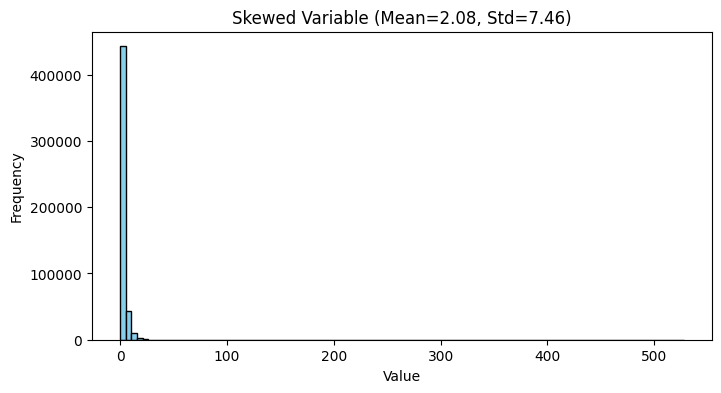

In [2]:

# Number of observations
n_obs = 500000

# Generate a base variable from an exponential distribution (skewed)
x = np.random.exponential(scale=3.5, size=n_obs)

# Inject zeros: set about 40% of the values to 0
p_zero = 0.5
zero_mask = np.random.rand(n_obs) < p_zero
x[zero_mask] = 0

# Introduce outliers: randomly select 1% of the samples and multiply by a high factor (e.g., 20)
n_outliers = int(0.01 * n_obs)
outlier_indices = np.random.choice(n_obs, n_outliers, replace=False)
x[outlier_indices] = x[outlier_indices] * 20

# Plotting to visualize the skewness and outliers
plt.figure(figsize=(8, 4))
plt.hist(x, bins=100, color='skyblue', edgecolor='black')
plt.title(f"Skewed Variable (Mean={np.mean(x):.2f}, Std={np.std(x):.2f})")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# define allocation 
df = pd.DataFrame({'metric': x})

# Sample size need it to identify a given effect

Let's say we can to identify an effect of at least 0.3. Not such a big effect given the mean of our mock variable is 2.09. We define different scenarios: 

- Allocation 50/50
- Allocation 90/10 

## 50/50 allocation

Let's get the sample size needed to detect an effect of 0.3:

In [3]:
allocation = 0.5
total_sample = 22000
control = int(total_sample * (1-allocation))
treatment = int(total_sample * allocation)

p = PowerSim(metric='average', relative_effect=False, variants=1, 
             nsim=1000, alpha=0.05, alternative='two-tailed')

p.get_power_from_data(df=df, metric_col='metric', effect=[0.3], sample_size=[control, treatment])

,comparisons,power
0,"(0, 1)",0.822


In [7]:
# create 100 samples 
dataframes = [] 

for i in range(100):
    temp = df.copy()
    temp = temp.sample(total_sample, replace=False)
    temp['random'] = np.random.rand(temp.shape[0])
    temp['treatment'] = (temp['random'] < allocation).astype(int)
    temp['experiment'] = i
    temp['metric'] = np.where(temp['treatment'] == 1, temp['metric'] + 0.3, temp['metric'])
    dataframes.append(temp)

sdf = pd.concat(dataframes, axis=0)
sdf = spark.createDataFrame(sdf)
sdf = sdf.repartition(300)
spark.conf.set("spark.sql.shuffle.partitions", 300)

/opt/homebrew/Cellar/apache-spark/3.5.4/libexec/python/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [10]:
from experiment_utils import ExperimentAnalyzer

analyzer = ExperimentAnalyzer(
    sdf,
    treatment_col="treatment",
    outcomes='metric',
    experiment_identifier=["experiment"],
    )
analyzer.get_effects()

25/02/14 08:10:28 WARN TaskSetManager: Stage 310 contains a task of very large size (53778 KiB). The maximum recommended task size is 1000 KiB.
14/02/2025 08:10:29 AM No covariates specified, balance can't be assessed!      
25/02/14 08:10:29 WARN TaskSetManager: Stage 313 contains a task of very large size (53778 KiB). The maximum recommended task size is 1000 KiB.
14/02/2025 08:10:32 AM Processing: Row(experiment=65)                           
25/02/14 08:10:32 WARN TaskSetManager: Stage 319 contains a task of very large size (53778 KiB). The maximum recommended task size is 1000 KiB.
14/02/2025 08:10:33 AM Processing: Row(experiment=19)                           
25/02/14 08:10:33 WARN TaskSetManager: Stage 322 contains a task of very large size (53778 KiB). The maximum recommended task size is 1000 KiB.
14/02/2025 08:10:34 AM Processing: Row(experiment=54)                           
25/02/14 08:10:34 WARN TaskSetManager: Stage 325 contains a task of very large size (53778 KiB). The

In [8]:
rr = analyzer.results
p = rr.stat_significance.mean()
print(p)

moe = 1.96 * np.sqrt((p * (1 - p)) / (100))
moe

print(p - moe, p + moe)


0.78
0.6988077245053448 0.8611922754946553


## 10/50 allocation

In [7]:
allocation = 0.1
total_sample = 51000
control = int(total_sample * (1-allocation))
treatment = int(total_sample * allocation)

p = PowerSim(metric='average', relative_effect=False, variants=1, 
             nsim=1000, alpha=0.05, alternative='two-tailed')

p.get_power_from_data(df=df, metric_col='metric', effect=[0.3], sample_size=[control, treatment])

,comparisons,power
0,"(0, 1)",0.838


In [8]:
# create 100 samples 
dataframes = [] 

for i in range(100):
    temp = df.copy()
    temp = temp.sample(total_sample, replace=False)
    temp['random'] = np.random.rand(temp.shape[0])
    temp['treatment'] = (temp['random'] < allocation).astype(int)
    temp['experiment'] = i
    temp['metric'] = np.where(temp['treatment'] == 1, temp['metric'] + 0.3, temp['metric'])
    dataframes.append(temp)

sdf = pd.concat(dataframes, axis=0)
sdf = spark.createDataFrame(sdf)
sdf = sdf.repartition(300)
spark.conf.set("spark.sql.shuffle.partitions", 300)

/opt/homebrew/Cellar/apache-spark/3.5.4/libexec/python/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [9]:
from experiment_utils import ExperimentAnalyzer

analyzer = ExperimentAnalyzer(
    sdf,
    treatment_col="treatment",
    outcomes='metric',
    experiment_identifier=["experiment"],
    )
analyzer.get_effects()

25/02/13 21:40:21 WARN TaskSetManager: Stage 309 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
25/02/13 21:40:23 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
13/02/2025 09:40:23 PM No covariates specified, balance can't be assessed!      
25/02/13 21:40:23 WARN TaskSetManager: Stage 312 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
25/02/13 21:40:25 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
13/02/2025 09:40:28 PM Processing: Row(experiment=65)                           
25/02/13 21:40:28 WARN TaskSetManager: Stage 318 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:40:30 PM Processing: Row(experiment=19)                           
25/02/13 21:40:30 WARN TaskSetManager: Stage 321 contains a task of very large size (124656 KiB). The maximum recommended task 

Py4JJavaError: An error occurred while calling o1249.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 510.0 failed 1 times, most recent failure: Lost task 0.0 in stage 510.0 (TID 49972) (192.168.1.43 executor driver): java.net.SocketException: Broken pipe (Write failed)
	at java.base/java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.base/java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:110)
	at java.base/java.net.SocketOutputStream.write(SocketOutputStream.java:150)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.net.SocketException: Broken pipe (Write failed)
	at java.base/java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.base/java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:110)
	at java.base/java.net.SocketOutputStream.write(SocketOutputStream.java:150)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at java.base/java.io.FilterOutputStream.write(FilterOutputStream.java:108)
	at org.apache.spark.api.python.PythonRDD$.write$1(PythonRDD.scala:310)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$writeIteratorToStream$1$adapted(PythonRDD.scala:322)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)


In [ ]:
rr = analyzer.results
p = rr.stat_significance.mean()
print(p)

moe = 1.96 * np.sqrt((p * (1 - p)) / (100))
moe

print(p - moe, p + moe)

0.81
0.7331090226359426 0.8868909773640575


# What about null effects and the false positive rate?

If use an alpha value of 0.05, if we repeat an experiment 100, we should get a false positive rate of 5%, that is, 5 tests will be false positive.

# 50/50 allocation

In [ ]:
allocation = 0.5
total_sample = 22000
dataframes = [] 

for i in range(100):
    temp = df.copy()
    temp = temp.sample(total_sample, replace=False)
    temp['random'] = np.random.rand(temp.shape[0])
    temp['treatment'] = (temp['random'] < allocation).astype(int)
    temp['experiment'] = i
    dataframes.append(temp)

sdf = pd.concat(dataframes, axis=0)
sdf = spark.createDataFrame(sdf)
sdf = sdf.repartition(300)
spark.conf.set("spark.sql.shuffle.partitions", 300)

/opt/homebrew/Cellar/apache-spark/3.5.4/libexec/python/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [ ]:
from experiment_utils import ExperimentAnalyzer

analyzer = ExperimentAnalyzer(
    sdf,
    treatment_col="treatment",
    outcomes='metric',
    experiment_identifier=["experiment"],
    )
analyzer.get_effects()

25/02/13 21:30:10 WARN TaskSetManager: Stage 952 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
25/02/13 21:30:12 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
13/02/2025 09:30:13 PM No covariates specified, balance can't be assessed!      
25/02/13 21:30:13 WARN TaskSetManager: Stage 955 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
25/02/13 21:30:15 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
25/02/13 21:30:15 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.


[20915.856s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 955.0 (TID 93024): Retried waiting for GCLocker too often allocating 8388610 words


13/02/2025 09:30:18 PM Processing: Row(experiment=65)                           
25/02/13 21:30:18 WARN TaskSetManager: Stage 961 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:30:20 PM Processing: Row(experiment=19)                           
25/02/13 21:30:20 WARN TaskSetManager: Stage 964 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:30:22 PM Processing: Row(experiment=54)                           
25/02/13 21:30:22 WARN TaskSetManager: Stage 967 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:30:24 PM Processing: Row(experiment=37)                           
25/02/13 21:30:25 WARN TaskSetManager: Stage 970 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:30:28 PM Processing: Row(experiment=77)                           
25/02/13 21:30:

In [ ]:
rr = analyzer.results
p = rr.stat_significance.mean()
print(p)

moe = 1.96 * np.sqrt((p * (1 - p)) / (100))
moe

print(p - moe, p + moe)

0.04
0.0015920008331597735 0.07840799916684023


# 90/10 allocation

In [ ]:
allocation = 0.1
total_sample = 51000
dataframes = [] 

for i in range(100):
    temp = df.copy()
    temp = temp.sample(total_sample, replace=False)
    temp['random'] = np.random.rand(temp.shape[0])
    temp['treatment'] = (temp['random'] < allocation).astype(int)
    temp['experiment'] = i
    dataframes.append(temp)

sdf = pd.concat(dataframes, axis=0)
sdf = spark.createDataFrame(sdf)
sdf = sdf.repartition(300)
spark.conf.set("spark.sql.shuffle.partitions", 300)

/opt/homebrew/Cellar/apache-spark/3.5.4/libexec/python/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [ ]:
from experiment_utils import ExperimentAnalyzer

analyzer = ExperimentAnalyzer(
    sdf,
    treatment_col="treatment",
    outcomes='metric',
    experiment_identifier=["experiment"],
    )
analyzer.get_effects()

25/02/13 21:35:15 WARN TaskSetManager: Stage 1261 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
25/02/13 21:35:17 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
13/02/2025 09:35:18 PM No covariates specified, balance can't be assessed!      
25/02/13 21:35:18 WARN TaskSetManager: Stage 1264 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
25/02/13 21:35:20 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
25/02/13 21:35:20 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.


[21220.913s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 1264.0 (TID 123428): Retried waiting for GCLocker too often allocating 8388610 words


25/02/13 21:35:21 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
13/02/2025 09:35:23 PM Processing: Row(experiment=65)                           
25/02/13 21:35:23 WARN TaskSetManager: Stage 1270 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:35:25 PM Processing: Row(experiment=19)                           
25/02/13 21:35:25 WARN TaskSetManager: Stage 1273 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:35:28 PM Processing: Row(experiment=54)                           
25/02/13 21:35:28 WARN TaskSetManager: Stage 1276 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000 KiB.
13/02/2025 09:35:30 PM Processing: Row(experiment=37)                           
25/02/13 21:35:30 WARN TaskSetManager: Stage 1279 contains a task of very large size (124656 KiB). The maximum recommended task size is 1000

In [10]:
rr = analyzer.results
p = rr.stat_significance.mean()
print(p)

moe = 1.96 * np.sqrt((p * (1 - p)) / (100))
moe

print(p - moe, p + moe)

14/02/2025 07:41:12 AM Run the `get_effects` function first!


AttributeError: 'NoneType' object has no attribute 'stat_significance'